## Import libs and data

In [19]:
import dask.dataframe as dd
import os
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay,roc_curve, auc, make_scorer
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import StandardScaler


In [20]:
final_dataset_path = '..\data\FEData_For_Modelling.parquet'

# Read the multi-part Parquet dataset
fds = dd.read_parquet(final_dataset_path)
fds.head(4000)

,user,O,C,E,A,N,FCwke,FCowh,FCwh,SDwke,SDowh,SDwh,CDwke,CDowh,CDwh,JDwke,JDowh,JDwh
0,AAB1302,38,41,10,38,28,23,37,142,0,1,10,0,0,0,40,81,246
1,AAB1762,32,39,18,18,33,0,194,654,0,9,14,0,0,4,0,243,679
2,AAC0904,31,30,36,18,28,0,0,0,0,22,144,0,5,34,0,499,4025
3,AAC1033,42,40,40,22,29,0,0,0,0,14,72,0,0,1,0,1,2
4,AAC1489,24,13,42,24,38,0,0,0,0,1,175,0,0,2,0,101,5058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ZRF1980,43,41,26,16,30,0,9,1272,0,16,298,0,0,11,0,28,494
1996,ZUR1449,31,42,12,36,17,0,0,0,0,1,7,0,65,296,0,293,1322
1997,ZVW1475,38,35,18,24,37,0,0,0,0,0,1,0,0,0,0,2,7
1998,ZWS0755,45,47,42,39,28,0,0,0,0,58,266,0,0,0,0,148,810


OWH: Outside Work Hours  
WH: Work Hours  
WKE: Weekend  
  
FC: files copied  
SD: Sus Domain  
CD: Cloud Domain  
JD: Job Domain  


## Add target labels

In [21]:
def list_files_in_folder(folder_path):
    files = []
    # Check if the folder path exists
    if os.path.exists(folder_path):
        # Iterate through all files in the folder
        for file_name in os.listdir(folder_path):
            # Check if the path is a file (not a directory)
            if os.path.isfile(os.path.join(folder_path, file_name)):
                files.append(file_name[7:-4])
    else:
        print(f"Folder '{folder_path}' does not exist.")
    return files

sus_users_list = list_files_in_folder("..\data\\r5.2-2")
fds["targetLabel"] = fds['user'].apply(lambda x: 1 if x in sus_users_list else 0, meta=('int'))

In [22]:
print("How many sus users: ",len(sus_users_list))
print(sus_users_list)

How many sus users:  30
['BYO1846', 'CHP1711', 'CIF1430', 'CKP0630', 'DCC1119', 'GWG0497', 'HIS1394', 'HMS1658', 'HSN0675', 'HXP0976', 'ICB1354', 'ITA0159', 'JAL0811', 'KSS1005', 'LVF1626', 'MCP0611', 'MDS0680', 'MGB1235', 'NAH1366', 'OKM1092', 'OSS1463', 'RRS0056', 'SIS0042', 'SNK1280', 'TMT0851', 'TNB1616', 'TRC1838', 'VCF1602', 'WDT1634', 'ZIE0741']


In [23]:
(fds["targetLabel"] == 1).sum().compute()

30

In [24]:
y = fds["targetLabel"].compute()
X = fds.drop(columns=["targetLabel",]).compute()
# X = fds.drop(columns=["targetLabel","user"]).compute()

## Preprocessing and Split

In [25]:
X_train_w_name, X_test_w_name, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test = X_train_w_name.drop(columns=["user",]), X_test_w_name.drop(columns=["user",])
print("Train Labels before Resampling")
print(Counter(y_train))

Train Labels before Resampling
Counter({0: 1574, 1: 26})


In [26]:
from sklearn.preprocessing import StandardScaler
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## SVM

In [27]:
def make_binary_labels(labels):
    return np.where(labels == 1, -1, 1)

y_train_gs = make_binary_labels(y_train)
y_test_gs = make_binary_labels(y_test)


In [28]:
# Create a scorer using make_scorer
def custom_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, zero_division=1)

scorer = make_scorer(custom_f1_score, greater_is_better=True)

# defining parameter range 
param_grid = {
    'nu': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel type
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001, 0.0001, 1.0, 10.0]  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
}

grid = GridSearchCV(OneClassSVM(), param_grid, refit = True, verbose = 3, scoring=scorer) 

# fitting the model for grid search 
grid.fit(X_train_scaled, y_train_gs) 

# print best parameter after tuning 
print(grid.best_params_) 

# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 


Fitting 5 folds for each of 320 candidates, totalling 1600 fits
[CV 1/5] END gamma=scale, kernel=linear, nu=0.001;, score=0.630 total time=   0.0s
[CV 2/5] END gamma=scale, kernel=linear, nu=0.001;, score=0.819 total time=   0.0s
[CV 3/5] END gamma=scale, kernel=linear, nu=0.001;, score=0.737 total time=   0.0s
[CV 4/5] END gamma=scale, kernel=linear, nu=0.001;, score=0.844 total time=   0.0s
[CV 5/5] END gamma=scale, kernel=linear, nu=0.001;, score=0.848 total time=   0.0s
[CV 1/5] END gamma=scale, kernel=linear, nu=0.005;, score=0.320 total time=   0.0s
[CV 2/5] END gamma=scale, kernel=linear, nu=0.005;, score=0.919 total time=   0.0s
[CV 3/5] END gamma=scale, kernel=linear, nu=0.005;, score=0.754 total time=   0.0s
[CV 4/5] END gamma=scale, kernel=linear, nu=0.005;, score=0.751 total time=   0.0s
[CV 5/5] END gamma=scale, kernel=linear, nu=0.005;, score=0.808 total time=   0.0s
[CV 1/5] END gamma=scale, kernel=linear, nu=0.01;, score=0.685 total time=   0.0s
[CV 2/5] END gamma=scale

[CV 5/5] END gamma=scale, kernel=linear, nu=0.01;, score=0.598 total time=   0.0s
[CV 1/5] END gamma=scale, kernel=linear, nu=0.05;, score=0.283 total time=   0.0s
[CV 2/5] END gamma=scale, kernel=linear, nu=0.05;, score=0.519 total time=   0.0s
[CV 3/5] END gamma=scale, kernel=linear, nu=0.05;, score=0.346 total time=   0.0s
[CV 4/5] END gamma=scale, kernel=linear, nu=0.05;, score=0.205 total time=   0.0s
[CV 5/5] END gamma=scale, kernel=linear, nu=0.05;, score=0.754 total time=   0.0s
[CV 1/5] END gamma=scale, kernel=linear, nu=0.1;, score=0.274 total time=   0.0s
[CV 2/5] END gamma=scale, kernel=linear, nu=0.1;, score=0.779 total time=   0.0s
[CV 3/5] END gamma=scale, kernel=linear, nu=0.1;, score=0.475 total time=   0.0s
[CV 4/5] END gamma=scale, kernel=linear, nu=0.1;, score=0.286 total time=   0.0s
[CV 5/5] END gamma=scale, kernel=linear, nu=0.1;, score=0.936 total time=   0.0s
[CV 1/5] END gamma=scale, kernel=linear, nu=0.2;, score=0.245 total time=   0.0s
[CV 2/5] END gamma=sca

In [31]:
best_clf = grid

##############################
Train Evaluation
##############################
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        26
           1       0.98      0.99      0.99      1574

    accuracy                           0.98      1600
   macro avg       0.49      0.50      0.49      1600
weighted avg       0.97      0.98      0.97      1600



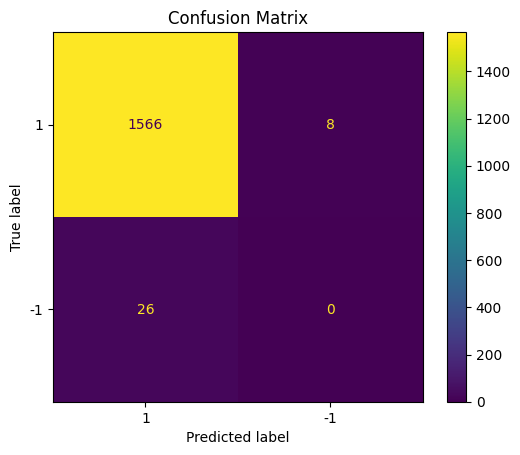

##############################
Test Evaluation
##############################
              precision    recall  f1-score   support

     Inliers       0.99      1.00      1.00       396
    Outliers       1.00      0.25      0.40         4

    accuracy                           0.99       400
   macro avg       1.00      0.62      0.70       400
weighted avg       0.99      0.99      0.99       400



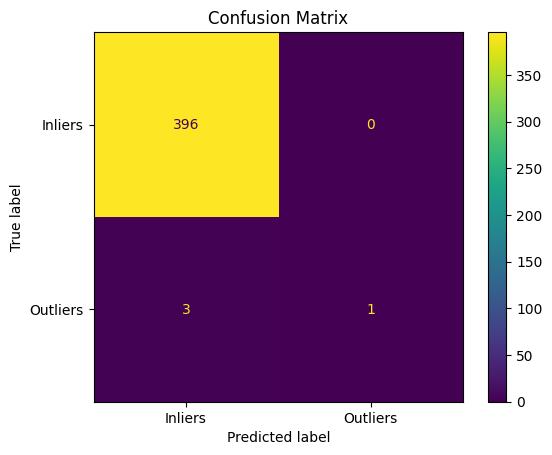

In [32]:
print("##############################")
print("Train Evaluation")
print("##############################")
# wider param grid, no smote
train_pred = best_clf.predict(X_train_scaled) 
print(classification_report(y_train_gs, train_pred)) 


conf_matrix = confusion_matrix(y_train_gs, train_pred, labels=[1, -1])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                display_labels=[1, -1])
disp.plot()
plt.title('Confusion Matrix')
plt.show()

# (-1 for outliers, 1 for inliers)
print("##############################")
print("Test Evaluation")
print("##############################")

test_pred = best_clf.predict(X_test_scaled) 
labels = [1, -1]  # -1 for Outliers, 1 for Inliers

print(classification_report(y_true=y_test_gs, y_pred=test_pred,labels=labels, target_names=['Inliers', 'Outliers'])) 

conf_matrix = confusion_matrix(y_test_gs, test_pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Inliers', 'Outliers'])
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [34]:
def plot_roc(clf):
    # Decision function scores (distances to the separating hyperplane)
    scores = clf.decision_function(X_test_scaled)
    
    # Rescale the scores to range [0, 1]
    scores_rescaled = (scores - scores.min()) / (scores.max() - scores.min())

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, scores_rescaled)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) for One-Class SVM')
    plt.legend(loc="lower right")
    plt.show()

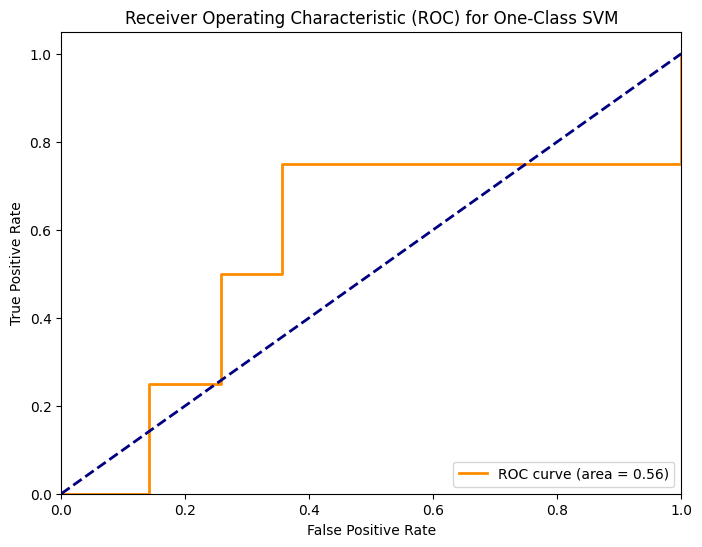

In [35]:
# ROC for best SVM, grid search
plot_roc(best_clf)

## Risk scores

In [117]:
class riskScore:
    def __init__(self, clf, X):
        self.clf = clf
        distances = clf.decision_function(X)
        self.min = min(distances)
        self.max = max(distances)
        
    def get_risk_score(self, X):
        def min_max_scaling(value, new_min, new_max):
            old_min = min(min(value), self.min) 
            old_max = max(max(value), self.max)
            if old_max == old_min:
                return np.zeros_like(value) if old_max == 0 else np.ones_like(value) * ((new_max - new_min) / 2) + new_min
            else:
                scaled_value = ((value - old_min) / (old_max - old_min)) * (new_max - new_min) + new_min
                return scaled_value
        
        # Distance from decision boundary where positive = non-anomaly and negative = anomaly
        distances = self.clf.decision_function(X)
        
        # Scale negative distances on the negative scale and positive distances on the positive scale
        neg_distances = distances[distances < 0]
        pos_distances = distances[distances >= 0]
        
        scaled_neg = min_max_scaling(neg_distances, -1, 0)
        scaled_pos = min_max_scaling(pos_distances, 0, 1)
        
        # Combine scaled distances
        risk_scores = np.empty_like(distances)
        risk_scores[distances < 0] = scaled_neg
        risk_scores[distances >= 0] = scaled_pos
        
        return risk_scores


In [118]:
risk_scorer = riskScore(best_clf, X_train_scaled)
train_risk = risk_scorer.get_risk_score(X_train_scaled)
test_risk = risk_scorer.get_risk_score(X_test_scaled)

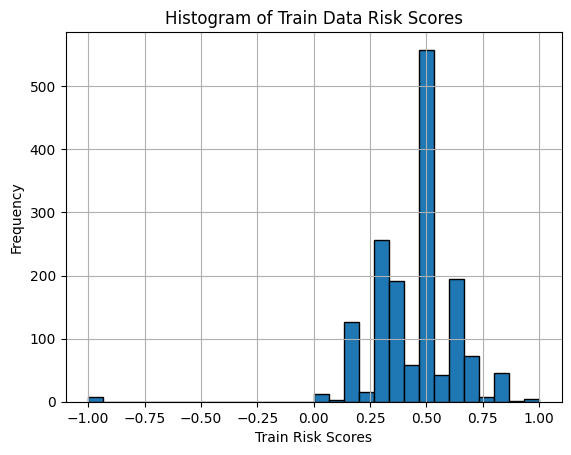

In [119]:
# Plot histogram
plt.hist(train_risk, bins=30, edgecolor='black') 
plt.xlabel('Train Risk Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Train Data Risk Scores')
plt.grid(True)
plt.show()

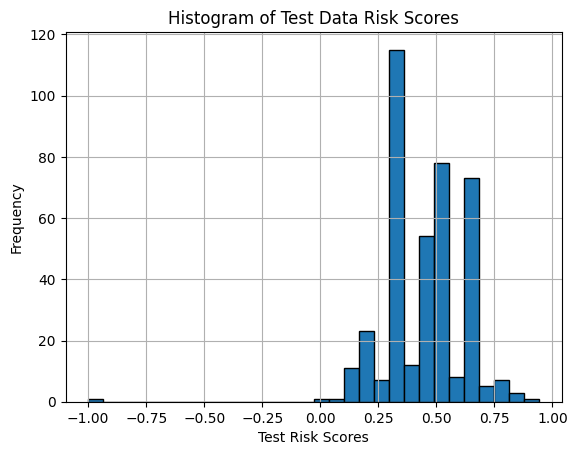

In [120]:

# Plot histogram
plt.hist(test_risk, bins=30, edgecolor='black')
plt.xlabel('Test Risk Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Test Data Risk Scores')
plt.grid(True)
plt.show()

In [121]:
print("Example Train Risk Scores:")
print(train_risk[:10])  
print("\nExample Test Risk Scores:")
print(test_risk[:10])

Example Train Risk Scores:
[0.17298148 0.33871871 0.4741276  0.48983757 0.67972649 0.15268044
 0.64164501 0.33927537 0.67707529 0.49185743]

Example Test Risk Scores:
[0.82832092 0.15361279 0.33916217 0.50896493 0.49013835 0.48913336
 0.47290427 0.30709944 0.32241756 0.49443545]


## Export CSV of FP,FN,TP names for entire dataset

In [143]:
train_pred = np.where(train_pred == 1, 0, 1)
test_pred = np.where(test_pred == 1, 0, 1)

In [144]:
# Filter out empty entries before concatenating
fp_train_names = X_train_w_name.iloc[np.where((y_train == 0) & (train_pred == 1))[0]]["user"]
fp_test_names = X_test_w_name.iloc[np.where((y_test == 0) & (test_pred == 1))[0]]["user"]

fn_train_names = X_train_w_name.iloc[np.where((y_train == 1) & (train_pred == 0))[0]]["user"]
fn_test_names = X_test_w_name.iloc[np.where((y_test == 1) & (test_pred == 0))[0]]["user"]

tp_train_names = X_train_w_name.iloc[np.where((y_train == 1) & (train_pred == 1))[0]]["user"]
tp_test_names = X_test_w_name.iloc[np.where((y_test == 1) & (test_pred == 1))[0]]["user"]

# Concatenate false positives and false negatives dataframes
fp_names = pd.concat([fp_train_names, fp_test_names], ignore_index=True)
fn_names = pd.concat([fn_train_names, fn_test_names], ignore_index=True)
tp_names = pd.concat([tp_train_names, tp_test_names], ignore_index=True)

# Create a dictionary with fp and fn dataframes
data = {'False Positives': fp_names, 'False Negatives': fn_names, 'True Positives': tp_names}

# Create a Pandas DataFrame
df = pd.DataFrame(data)

# Export the DataFrame to a CSV file
df.to_csv('minority_users_svm.csv', index=False)

## SMOTE

In [10]:
from imblearn.over_sampling import SMOTE

# transform the dataset
oversample = SMOTE(sampling_strategy=0.4)
resampled_X_train, resampled_y_train = oversample.fit_resample(X_train, y_train)
scaler = StandardScaler()
resampled_X_train = scaler.fit_transform(resampled_X_train)
X_test_scaled = scaler.transform(X_test)

print("Train Labels after Resampling")
print(Counter(resampled_y_train))

Train Labels after Resampling
Counter({0: 1574, 1: 629})


In [11]:
def make_binary_labels(labels):
    return np.where(labels == 1, -1, 1)

y_train_smote = make_binary_labels(resampled_y_train)
y_test_smote = make_binary_labels(y_test)


In [12]:
def custom_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, zero_division=1)

# Create a scorer using make_scorer
scorer = make_scorer(custom_f1_score, greater_is_better=True)

# defining parameter range 
param_grid = {
    'nu': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel type
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001, 0.0001, 1.0, 10.0]  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
}

smote_clf = GridSearchCV(OneClassSVM(), param_grid, refit = True, verbose = 3, scoring=scorer) 

# fitting the model for grid search 
smote_clf.fit(resampled_X_train, y_train_smote) 

# print best parameter after tuning 
print(smote_clf.best_params_) 

# print how our model looks after hyper-parameter tuning 
print(smote_clf.best_estimator_) 


Fitting 5 folds for each of 320 candidates, totalling 1600 fits
[CV 1/5] END gamma=scale, kernel=linear, nu=0.001;, score=0.711 total time=   0.0s
[CV 2/5] END gamma=scale, kernel=linear, nu=0.001;, score=0.939 total time=   0.0s
[CV 3/5] END gamma=scale, kernel=linear, nu=0.001;, score=0.758 total time=   0.0s
[CV 4/5] END gamma=scale, kernel=linear, nu=0.001;, score=0.683 total time=   0.0s
[CV 5/5] END gamma=scale, kernel=linear, nu=0.001;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=scale, kernel=linear, nu=0.005;, score=0.228 total time=   0.0s
[CV 2/5] END gamma=scale, kernel=linear, nu=0.005;, score=0.917 total time=   0.0s
[CV 3/5] END gamma=scale, kernel=linear, nu=0.005;, score=0.731 total time=   0.0s
[CV 4/5] END gamma=scale, kernel=linear, nu=0.005;, score=0.477 total time=   0.0s
[CV 5/5] END gamma=scale, kernel=linear, nu=0.005;, score=0.000 total time=   0.0s
[CV 1/5] END gamma=scale, kernel=linear, nu=0.01;, score=0.489 total time=   0.0s
[CV 2/5] END gamma=scale

##############################
Train Evaluation
##############################
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       629
           1       0.71      1.00      0.83      1574

    accuracy                           0.71      2203
   macro avg       0.36      0.50      0.42      2203
weighted avg       0.51      0.71      0.59      2203



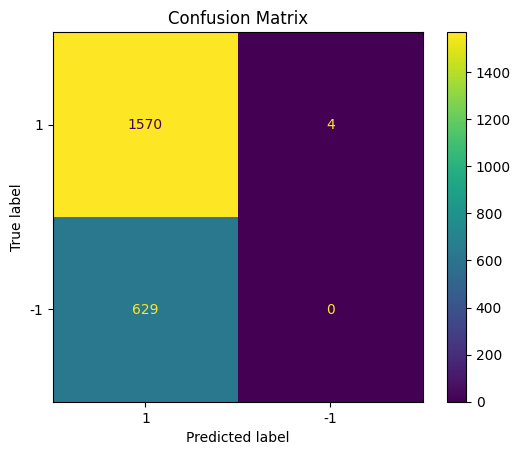

##############################
Test Evaluation
##############################
              precision    recall  f1-score   support

     Inliers       0.99      1.00      0.99       396
    Outliers       0.00      0.00      0.00         4

    accuracy                           0.99       400
   macro avg       0.49      0.50      0.50       400
weighted avg       0.98      0.99      0.98       400



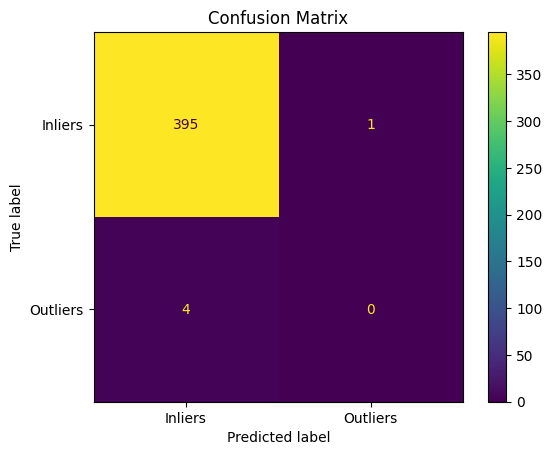

In [13]:
print("##############################")
print("Train Evaluation")
print("##############################")
# wider param grid, no smote
smote_train_pred = smote_clf.predict(resampled_X_train) 
print(classification_report(y_train_smote, smote_train_pred)) 


conf_matrix = confusion_matrix(y_train_smote, smote_train_pred, labels=[1, -1])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                display_labels=[1, -1])
disp.plot()
plt.title('Confusion Matrix')
plt.show()

# (-1 for outliers, 1 for inliers)
print("##############################")
print("Test Evaluation")
print("##############################")

smote_test_pred = smote_clf.predict(X_test_scaled) 
labels = [1, -1]  # -1 for Outliers, 1 for Inliers

print(classification_report(y_true=y_test_smote, y_pred=smote_test_pred,labels=labels, target_names=['Inliers', 'Outliers'])) 

conf_matrix = confusion_matrix(y_test_smote, smote_test_pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Inliers', 'Outliers'])
disp.plot()
plt.title('Confusion Matrix')
plt.show()

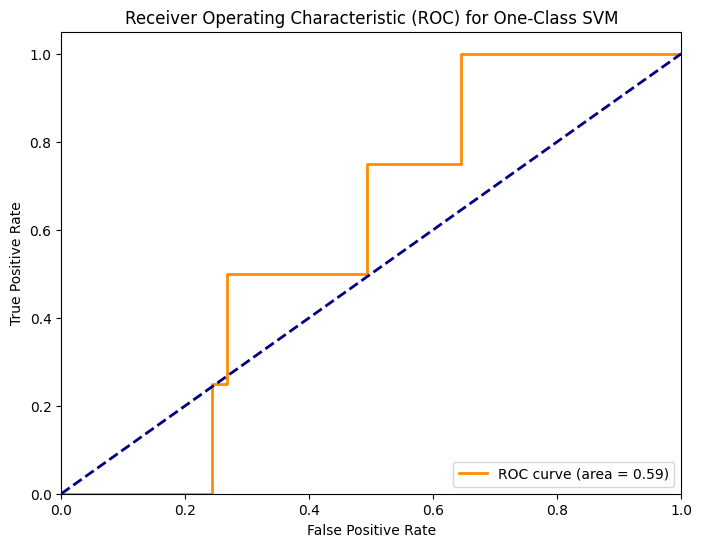

In [36]:
# ROC for best SVM, grid search
plot_roc(smote_clf)